# Test Var(N, m) Relation

In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [2]:
from stack import *
inst = 1
filt_order = 3
ifield = 6
sample_type = 'jack_region'
dx = 1200
unmask=True

cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                    (inst,ifield,'psmap'),
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                  (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])
if inst==1:
    mask_inst = mask_inst1
else:
    mask_inst = mask_inst2

cbmap = image_poly_filter(cbmap, strmask*mask_inst, degree=filt_order)

In [61]:
Nsub = 16

# Nsigdata = {}
for im in [3]:#range(4):
    Nsigdata[im] = {}
    
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

    stacking_class = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                        load_from_file=True, BGsub=False, subsub=True)
    stackdat = stacking_class.stackdat
    cliplim = stacking_class._stackihl_PS_cliplim()

    srctype = 's'
    srcdat = ps_src_select(inst, ifield, m_min, m_max,
        [mask_inst1, mask_inst2], sample_type=sample_type, Nsub=Nsub)

    # start stacking
    rbinedges = stackdat['rbinedges']/0.7 # subpix unit
    rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit

    Ilist_dict = {}
    Ilist_dict['Nsrc'] = np.zeros(Nsub)
    start_time = time.time()
    for isub in range(srcdat['Nsub']):
        stackdat['sub'][isub] = {}

        xls = srcdat['sub'][isub]['x' + srctype + '_arr']
        yls = srcdat['sub'][isub]['y' + srctype + '_arr']

        ms = srcdat['sub'][isub]['m' + srctype + '_arr']
        rs = get_mask_radius_th(ifield, ms) # arcsec

        print('stacking %s %d < m < %d, #%d subsample, %d sources, t = %.2f min'\
          %(fieldnamedict[ifield], m_min, m_max,isub,\
           len(xls), (time.time()-start_time)/60))

        Ilist_dict[isub] = []
        for i,(xl,yl,r) in enumerate(zip(xls,yls,rs)):
            cbmapi = cbmap*strmask*mask_inst
            psmapi = psmap*strmask*mask_inst
            maski = strmask*mask_inst
            radmap = make_radius_map(cbmap, xl,yl) # large pix units
            sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
            cbmapi[sp1] = cbmap[sp1]
            psmapi[sp1] = psmap[sp1]
            unmaskpix = np.zeros_like(strmask)
            unmaskpix[sp1] = 1
            maski[sp1] = 1
            if len(sp1[0])>0 and unmask:
                for ibin in [0]:
                    if cliplim['CBmax'][ibin] == np.inf:
                        continue
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap > cliplim['CBmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap < cliplim['CBmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap > cliplim['PSmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap < cliplim['PSmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0


            # unmask source
            mcb = cbmapi * maski
            mps = psmapi * maski
            xl, yl = int(np.round(xl)), int(np.round(yl))

            if maski[xl,yl]==1:
                Ilist_dict[isub].append(mcb[xl,yl])

        Ilist_dict['Nsrc'][isub] = len(Ilist_dict[isub])

    Nmin = np.min(Ilist_dict['Nsrc'])
    Nsrc_jk_arr = np.arange(Nmin).astype(int)+1
    sigma_arr = np.zeros(len(Nsrc_jk_arr))
    for iNsrc, Nsrc_jk in enumerate(Nsrc_jk_arr):
        Ijk = []
        for isub in range(Nsub):
            Ijk.append(np.mean(Ilist_dict[isub][:Nsrc_jk]))
        sigma_arr[iNsrc] = np.std(Ijk)
        
    Nsigdata[im] = {}
    Nsigdata[im]['N_arr'+srctype] = Nsrc_jk_arr*Nsub
    Nsigdata[im]['sig_arr'+srctype] = sigma_arr
clear_output()
with open('./Nsigdata.pkl', "wb") as f:
    pickle.dump(Nsigdata, f)

In [169]:
Nsides = int(np.sqrt(Nsub))
axlims = np.linspace(-0.5, 1023.5, Nsides+1)
ymins, xmins = np.meshgrid(axlims[:-1], axlims[:-1])
ymaxs, xmaxs = np.meshgrid(axlims[1:], axlims[1:])
ymins =(ymins + 0.5).astype(int)
xmins =(xmins + 0.5).astype(int)
ymaxs =(ymaxs - 0.5).astype(int)
xmaxs =(xmaxs - 0.5).astype(int)

meanI_arr = []
Nsrc_jk_arr = Nsigdata[im]['N_arr'+srctype] / Nsub
for isub in range(srcdat['Nsub']):
    cbmapsub = cbmap*strmask*mask_inst
    ymin, xmin = ymins.flatten()[isub], xmins.flatten()[isub]
    ymax, xmax = ymaxs.flatten()[isub], xmaxs.flatten()[isub]
    cbmapsub = cbmapsub[xmin:xmax+1, ymin:ymax+1]
    meanI_arr.append(np.mean(cbmapsub[cbmapsub!=0]))
sig2_bg = np.var(meanI_arr)
print('sig_bg^2 = %.3f'%sig2_bg)

sig_bg^2 = 50.774


In [68]:
with open('./Nsigdata.pkl', "rb") as f:
    Nsigdata = pickle.load(f)

Text(0, 0.5, '$N\\sigma^2\\,/\\,I^2$')

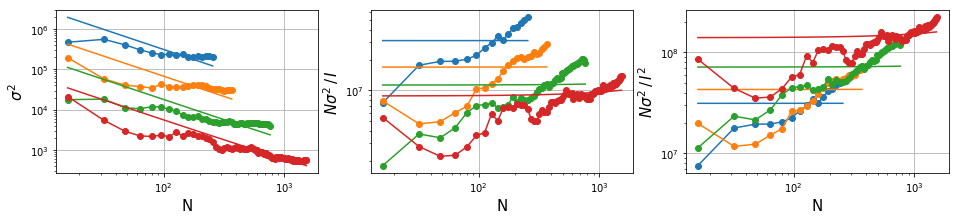

In [170]:
d_arr = np.array([])
N_arr = np.array([])
I_arr = np.array([])
im_arr = np.array([])

for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    Ns = Nsigdata[im]['N_arr'+srctype]
    sig2s = Nsigdata[im]['sig_arr'+srctype]**2 - sig2_bg
    I = 10**(-im/2.5)
    
    d_arr = np.concatenate((d_arr, Ns*sig2s))
    N_arr = np.concatenate((N_arr, Ns))
    I_arr = np.concatenate((I_arr, np.ones_like(Ns)*I))
    im_arr = np.concatenate((im_arr, np.ones_like(Ns)*im))
    
A = np.stack((np.ones_like(d_arr), I_arr, I_arr**2), axis=1)
params = np.linalg.inv(A.T@A)@A.T@(d_arr)
mod_arr = (A@params) / N_arr + sig2_bg

fig, ax = plt.subplots(1, 3, figsize = (16,3))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    Ns = Nsigdata[im]['N_arr'+srctype]
    sigs = Nsigdata[im]['sig_arr'+srctype]
    I = 10**(-im/2.5)
    mods = mod_arr[im_arr==im]
    ax[0].loglog(Ns, sigs**2,'o-', c='C'+str(im), label='%d < m < %d'%(m_min, m_max))
    ax[1].loglog(Ns, Ns*sigs**2/I,'o-', c='C'+str(im), label='%d < m < %d'%(m_min, m_max))
    ax[2].loglog(Ns, Ns*sigs**2/I**2,'o-', c='C'+str(im), label='%d < m < %d'%(m_min, m_max))
    ax[0].loglog(Ns, mods,'-', c='C'+str(im), label='%d < m < %d'%(m_min, m_max))
    ax[1].loglog(Ns, Ns*mods/I,'-', c='C'+str(im), label='%d < m < %d'%(m_min, m_max))
    ax[2].loglog(Ns, Ns*mods/I**2,'-', c='C'+str(im), label='%d < m < %d'%(m_min, m_max))

# ax[0].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel('N',fontsize=15)
ax[1].set_xlabel('N',fontsize=15)
ax[2].set_xlabel('N',fontsize=15)
ax[0].set_ylabel(r'$\sigma^2$',fontsize=15)
ax[1].set_ylabel(r'$N\sigma^2\,/\,I$',fontsize=15)
ax[2].set_ylabel(r'$N\sigma^2\,/\,I^2$',fontsize=15)


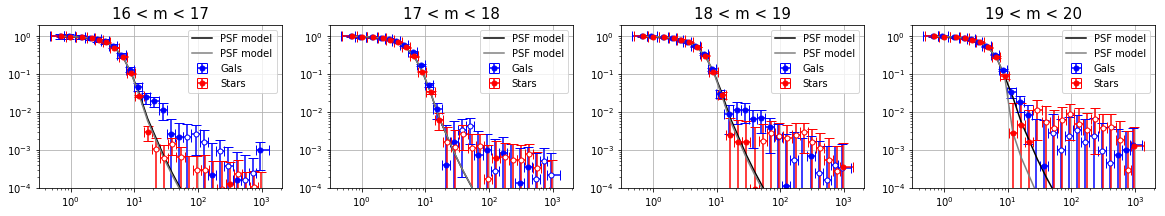

In [36]:
from psfstack import *
from psfsynth import *

inst = 1
filt_order = filt_order_dict[inst]
ifield = 7

fig, ax = plt.subplots(1, 4, figsize = (20,3))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):

    stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                load_from_file=True, BGsub=False).stackdat

    plot_err_log(stackdat['rbins']*0.95, 
                 stackdat['profcb']/stackdat['profcb'][0],
                 np.sqrt(np.diag(stackdat['cov']['profcb']))/stackdat['profcb'][0],
                 ax=ax[im], color='b',
                 label=r'Gals')

    profdat = run_psf_combine(inst, ifield, savedata=False, idx_comb=(8,10))
    plot_err_log(profdat['rbins'], 
                 profdat[im]['profcb']/profdat[im]['profcb'][0],
                 profdat[im]['profcb_err']/profdat[im]['profcb'][0],
                 ax=ax[im], color='r',label=r'Stars')

    ax[im].loglog(profdat['rbins'], 
                  profdat[im]['comb']['profcb']/profdat[im]['comb']['profcb'][0],
                  'k', label='PSF model')

    profdat = run_psf_combine(inst, ifield, savedata=False, idx_comb=(9,10))
    ax[im].loglog(profdat['rbins'], 
                  profdat[im]['comb']['profcb']/profdat[im]['comb']['profcb'][0], 
                  'grey',label='PSF model')

    ax[im].set_ylim([1e-4, 2])
    ax[im].grid()
    ax[im].legend()
    ax[im].set_title('%d < m < %d'%(m_min, m_max),fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/psf_gal.png', dpi = 100, bbox_inches='tight')

Re2 = 2.14, A1h = 2.11, A2h = 0.72


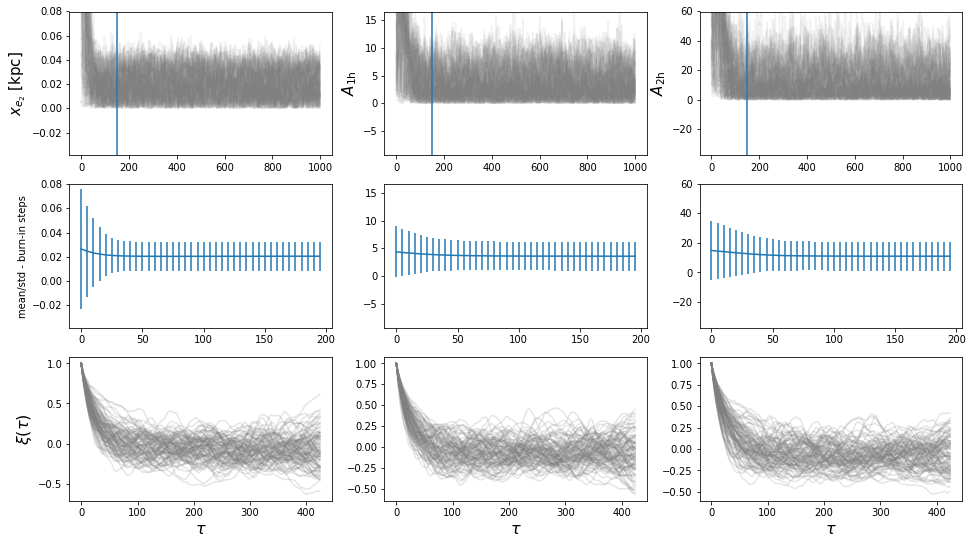

In [1]:
from run_fit import *

inst = 1
ifield = 7
im = 0
Npar = 3
burn_in = 150
plot_autocorr = True
#============================================
subsub = True if im==0 else False

R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']

if ifield in [4,5,6,7,8]:
    savename = 'mcmc_'+ str(Npar) + 'par_' + fieldnamedict[ifield] + \
    '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'
elif ifield is None:
    savename = 'mcmc_3par_joint' + \
    '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'

if subsub:
    savename = savename[:-4] + '_sub.npy'

chaindir = mypaths['alldat'] + 'TM' + str(inst) + '/'
samples = np.load(chaindir + savename)
flatsamps = samples.copy()
Nsteps, Nwalkers, _ = flatsamps.shape

if plot_autocorr:
    fig, ax = plt.subplots(3, 3, figsize = (16,9))
else:
    fig, ax = plt.subplots(2, 3, figsize = (16,6))
for i in range(flatsamps.shape[1]):
    ax[0][0].plot(flatsamps[:,i,0], c='grey', alpha=0.1)
    if Npar==3:
        ax[0][1].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[0][2].plot(flatsamps[:,i,2], c='grey', alpha=0.1)
        if flatsamps[300,i,1] > 100:
            ax[0][1].plot(flatsamps[:,i,1], c='b', alpha=0.1)
            ax[0][0].plot(flatsamps[:,i,0], c='b', alpha=0.1)
            ax[0][2].plot(flatsamps[:,i,2], c='b', alpha=0.1)
    else:
        ax[0][2].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[0][1].axis('off')
    
ax[0][0].axvline(burn_in)
ax[0][1].axvline(burn_in)
ax[0][2].axvline(burn_in)

for ipar in range(Npar):
    m = [np.mean(flatsamps[i:,:,ipar]) for i in np.arange(0,200,5)]
    e = [np.std(flatsamps[i:,:,ipar]) for i in np.arange(0,200,5)]
    ax[1][ipar].errorbar(np.arange(0,200,5), m, e)
    ax[0][ipar].set_ylim([m[-1]-5*e[-1], m[-1]+5*e[-1]])
    ax[1][ipar].set_ylim([m[-1]-5*e[-1], m[-1]+5*e[-1]])
    
ax[1][0].set_ylabel('mean/std - burn-in steps')
ax[0][0].set_ylabel(r"$x_{e_2}$ [kpc]", fontsize=15)
ax[0][1].set_ylabel(r"$A_{\rm 1h}$", fontsize=15)
ax[0][2].set_ylabel(r"$A_{\rm 2h}$", fontsize=15)

fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield,subsub=subsub)
Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
print('Re2 = %.2f, A1h = %.2f, A2h = %.2f'%(Re2, A1h, A2h))

if plot_autocorr:
    for i in range(flatsamps.shape[1]):
        lags, autocorr = plot_atcr(flatsamps[burn_in:,i,0])
        ax[2][0].plot(lags, autocorr, c='grey',alpha=0.2)
        if Npar==3:
            lags, autocorr = plot_atcr(flatsamps[burn_in:,i,1])
            ax[2][1].plot(lags, autocorr, c='grey',alpha=0.2)
            lags, autocorr = plot_atcr(flatsamps[burn_in:,i,2])
            ax[2][2].plot(lags, autocorr, c='grey',alpha=0.2)
        else:
            lags, autocorr = plot_atcr(flatsamps[burn_in:,i,1])
            ax[2][2].plot(lags, autocorr, c='grey',alpha=0.2)
    ax[2][0].set_xlabel(r'$\tau$', fontsize=16)
    ax[2][1].set_xlabel(r'$\tau$', fontsize=16)
    ax[2][2].set_xlabel(r'$\tau$', fontsize=16)
    ax[2][0].set_ylabel(r'$\xi(\tau)$', fontsize=16)

plt.savefig('/Users/ytcheng/Desktop/chains.png', dpi = 100, bbox_inches='tight')

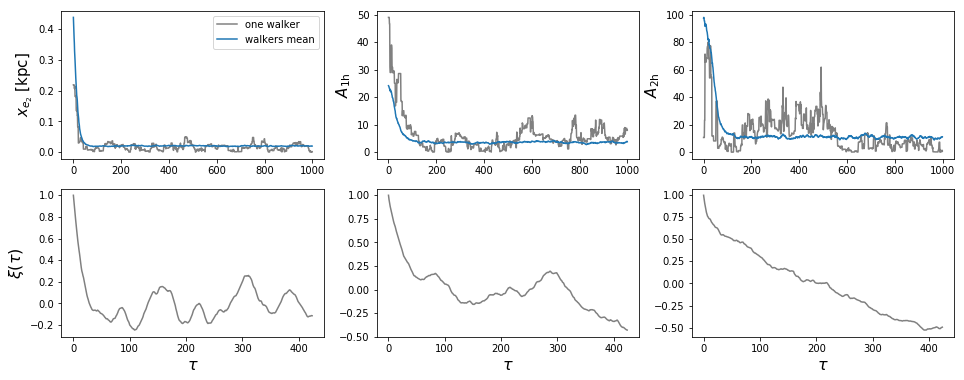

In [48]:
fig, ax = plt.subplots(2, 3, figsize = (16,6))
i = 0
ax[0][0].plot(flatsamps[:,i,0], c='grey', alpha=1, label='one walker')
ax[0][1].plot(flatsamps[:,i,1], c='grey', alpha=1)
ax[0][2].plot(flatsamps[:,i,2], c='grey', alpha=1)
ax[0][0].plot(np.mean(flatsamps[:,:,0],axis=1), label='walkers mean')
ax[0][1].plot(np.mean(flatsamps[:,:,1],axis=1))
ax[0][2].plot(np.mean(flatsamps[:,:,2],axis=1))

lags, autocorr = plot_atcr(flatsamps[burn_in:,i,0])
ax[1][0].plot(lags, autocorr, c='grey',alpha=1)
lags, autocorr = plot_atcr(flatsamps[burn_in:,i,1])
ax[1][1].plot(lags, autocorr, c='grey',alpha=1)
lags, autocorr = plot_atcr(flatsamps[burn_in:,i,2])
ax[1][2].plot(lags, autocorr, c='grey',alpha=1)
ax[0][0].legend()
ax[1][0].set_xlabel(r'$\tau$', fontsize=16)
ax[1][1].set_xlabel(r'$\tau$', fontsize=16)
ax[1][2].set_xlabel(r'$\tau$', fontsize=16)
ax[1][0].set_ylabel(r'$\xi(\tau)$', fontsize=16)
ax[0][0].set_ylabel(r"$x_{e_2}$ [kpc]", fontsize=15)
ax[0][1].set_ylabel(r"$A_{\rm 1h}$", fontsize=15)
ax[0][2].set_ylabel(r"$A_{\rm 2h}$", fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/chain.png', dpi = 100, bbox_inches='tight')

In [1]:
from run_fit import *
inst = 1
ifield = 7
im = 1
filt_order = filt_order_dict[inst]
subsub = False

param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order, subsub=subsub)
param_fit.get_profgal_model_interp()

Pre-computing model profiles for interpolation...


In [3]:
# R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
# Re2_arr = np.linspace(0.1,3,100)
# A2h_arr = np.linspace(0,100,100)
# A1h_arr = np.linspace(0,20,100)
# chi2_arr = np.zeros([len(Re2_arr),len(A1h_arr),len(A2h_arr)])
# for i,Re2 in enumerate(Re2_arr):
#     print(i,len(Re2_arr))
#     xe2 = Re2 / R200
#     for j,A1h in enumerate(A1h_arr):
#         for k,A2h in enumerate(A2h_arr):
#             chi2 = param_fit.get_chi2(xe2=xe2, A1h=A1h, A2h=A2h)
#             chi2_arr[i,j,k] = chi2

[1.88686869] [0.] [2.02020202]


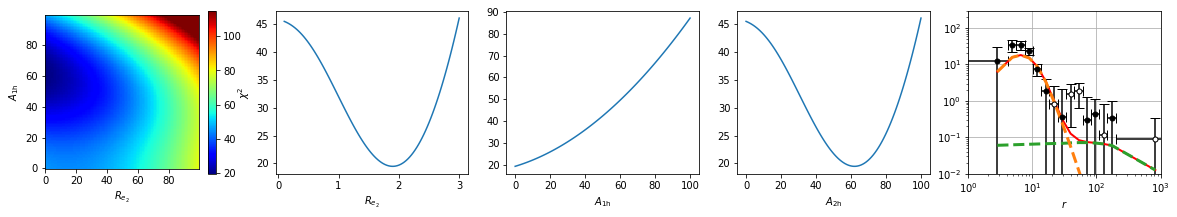

In [8]:
Re2_best_idx, A1h_best_idx, A2h_best_idx = np.where(chi2_arr==np.min(chi2_arr))
Re2_best, A1h_best, A2h_best = Re2_arr[Re2_best_idx], A1h_arr[A1h_best_idx], A2h_arr[A2h_best_idx]
print(Re2_best, A1h_best, A2h_best)

fig, ax = plt.subplots(1,5,figsize=(20,3))
imageclip(chi2_arr[:,:,A2h_best_idx].reshape(chi2_arr.shape[0],chi2_arr.shape[1]), ax=ax[0])
ax[1].plot(Re2_arr, chi2_arr[:, A1h_best_idx, A2h_best_idx].flatten())
ax[2].plot(A2h_arr, chi2_arr[Re2_best_idx,:,A2h_best_idx].flatten())
ax[3].plot(A2h_arr, chi2_arr[:,A1h_best_idx,A2h_best_idx].flatten())

r_arr = param_fit.rsubbins
rbinedges = param_fit.rsubbinedges
profd_arr = param_fit.profex_sub
profd_err = np.sqrt(np.diag(param_fit.covsub))
modelprof = param_fit.get_profexcess_model(Re2=Re2_best, A1h=A1h_best, A2h=A2h_best, fast=True)
profex_arr = modelprof['profex_sub']
prof1h_arr = modelprof['prof1h_sub']
prof2h_arr = modelprof['prof2h_sub']
profm_arr = profex_arr + prof1h_arr + prof2h_arr
plot_err_log(r_arr, 
             profd_arr,
             profd_err,
             xedges = rbinedges,
             ax=ax[4], color='k')
ax[4].loglog(r_arr, profm_arr,'r-', lw=2)
ax[4].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
ax[4].loglog(r_arr, prof1h_arr,'C0--', lw=3, label=r'$A_{\rm 1h}$ = %.2f'%A2h)
ax[4].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
ax[4].set_ylim([1e-2,3e2])
ax[4].set_xlim([1e0,1e3])
ax[4].grid()

ax[0].set_xlabel(r'$R_{e_2}$')
ax[0].set_ylabel(r'$A_{\rm 1h}$')
ax[1].set_xlabel(r'$R_{e_2}$')
ax[1].set_ylabel(r'$\chi^2$')
ax[2].set_xlabel(r'$A_{\rm 1h}$')
ax[3].set_xlabel(r'$A_{\rm 2h}$')
ax[4].set_xlabel(r'$r$')

plt.savefig('/Users/ytcheng/Desktop/grid.png', dpi = 100, bbox_inches='tight')

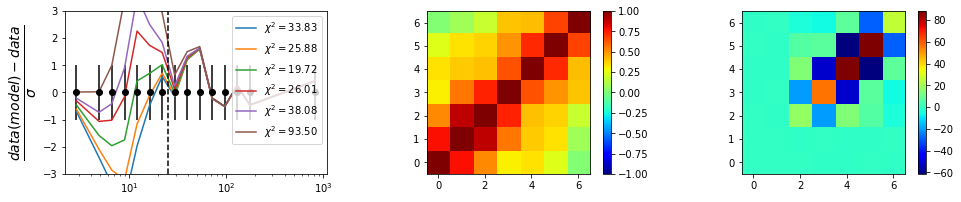

In [5]:
r = param_fit.rsubbins
d = param_fit.profex_sub
e = np.sqrt(np.diag(param_fit.covsub))
Covi = param_fit.covsub_inv
Cov = param_fit.covsub
Cov_norm = normalize_cov(Cov)

fig, ax = plt.subplots(1,3,figsize=(16,3))

for i,scale in enumerate([0.5,0.7,1,1.3,1.5,2]):
    modelprof = param_fit.get_profexcess_model(Re2=Re2_best*scale, A2h=A2h_best, fast=True)
    m = modelprof['profex_sub'] + modelprof['prof2h_sub']
    D = m - d
    D = D[np.newaxis,...]
    chi2_mat = (D.T@D)*Covi
    chi2 = np.sum(chi2_mat)
    
    ax[0].semilogx(r,(m-d)/e,'C'+str(i), label=r'$\chi^2=$%.2f'%(chi2))
ax[0].semilogx(r,(d-d)/e, 'k.')
ax[0].errorbar(r,(d-d)/e, e/e, c='k', fmt='o')
ax[0].set_ylim([-3,3])
ax[0].legend()
ax[0].set_ylabel(r'$\frac{data(model) - data}{\sigma}$', fontsize=20)
ax[0].axvline(np.sqrt(r[6]*r[7]),ls='--',c='k')

imageclip(Cov_norm[:7,:7],vmin=-1,vmax=1, ax=ax[1])
imageclip(chi2_mat[:7,:7], ax=ax[2])

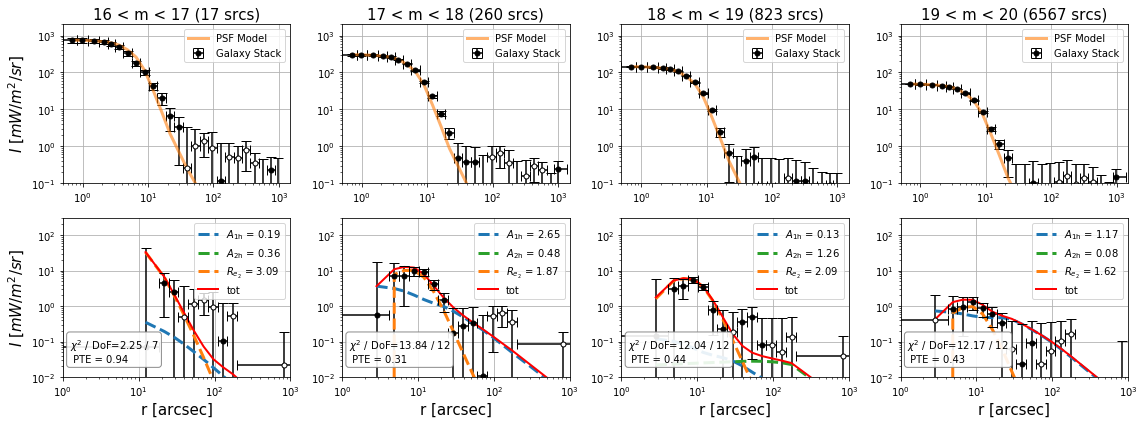

In [2]:
from run_fit import *

inst = 2
filt_order = filt_order_dict[inst]
for ifield in [8]:
    plt.close()
    fig, ax = plt.subplots(2, 4, figsize = (16,6))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        subsub = True if im==0 else False
        stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False, subsub=subsub).stackdat
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order,subsub=subsub)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield,subsub=subsub)
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],

        Nsrc = param_fit.Nsrc
        r_arr = param_fit.rsubbins
        profd_arr = param_fit.profex_sub
        profd_err = np.sqrt(np.diag(param_fit.covsub))
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        profex_arr = modelprof['profex_sub']
        prof1h_arr = modelprof['prof1h_sub']
        prof2h_arr = modelprof['prof2h_sub']

        rbinedges = param_fit.rsubbinedges        
        chi2, pte, dof, chi2_org = param_fit.get_chi2_pte(Npar=3,Re2=Re2, A1h=A1h, A2h=A2h)
        
        ax[1][im].loglog(r_arr, prof1h_arr,'C0--', lw=3, label=r'$A_{\rm 1h}$ = %.2f'%A1h)
        ax[1][im].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
        ax[1][im].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
        ax[1][im].loglog(r_arr, profex_arr + prof1h_arr + prof2h_arr,'r-', lw=2, label = 'tot')
        
        ax[1][im].text(0.03, 0.10,
                    r'$\chi^2$ / DoF=%.2f / %d'%(chi2,dof) + '\n PTE = %.2f'%(pte),
                    transform=ax[1][im].transAxes,
                    bbox={'boxstyle':'round','alpha':0.9, 'fc':'w','ec':'0.5'}, fontsize=10)
        
        plot_err_log(r_arr, 
                     profd_arr,
                     profd_err,
                     xedges = rbinedges,
                     ax=ax[1][im], color='k')

        plot_err_log(stackdat['rbins'], 
                     stackdat['profcb'],
                     np.sqrt(np.diag(stackdat['cov']['profcb'])),
                     ax=ax[0][im], color='k',label='Galaxy Stack')
        ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                      'C1', alpha=0.6, lw=3, label='PSF Model')

        ax[0][im].set_title('%d < m < %d (%d srcs)'%(m_min, m_max, Nsrc),fontsize=15)
        ax[0][im].set_ylim([1e-1,2e3])
        ax[0][im].set_xlim([5e-1,1.5e3])
        ax[0][im].legend(loc=1)
        ax[0][im].grid()
        ax[1][im].set_ylim([1e-2,3e2])
        ax[1][im].set_xlim([1e0,1e3])
        ax[1][im].grid()
        ax[1][im].legend(loc=1)
        ax[1][im].set_xlabel('r [arcsec]',fontsize=15)
    ax[0][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
    ax[1][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
#     fig.suptitle(fieldnamedict[ifield], fontsize=16)
    plt.tight_layout()